In [1]:
import os, sys
sys.path.append('/workspaces/python-trend-labeller')

In [2]:
import pandas as pd

from src.viz import plot_trend_labels
from src.returns_estimation import ReturnsEstimatorWithFees
from src.optimisation import Optimiser
from src.returns_estimation.fees_config import FeesConfig
from src.trend_labelling import BinaryCTL

Let's import the data. We will use only the closing prices for our time series.

In [3]:
df_list = []
for file in sorted(os.listdir('/workspaces/python-trend-labeller/notebooks/data')):
    if file.endswith('.parquet'):
        df_list.append(pd.read_parquet(f'/workspaces/python-trend-labeller/notebooks/data/{file}'))


In [4]:
df_concat = pd.concat(df_list).sort_values(by='t')
df_concat.drop_duplicates(subset='t', keep='first', inplace=True)


# Using a labeller

We can now instantiate a binary parametrized labeller.

In [5]:
from collections import Counter
from itertools import chain


concatenated_closing_prices = df_concat.c.to_list()

Uptrend periods: 4449, Downtrend periods: 7094


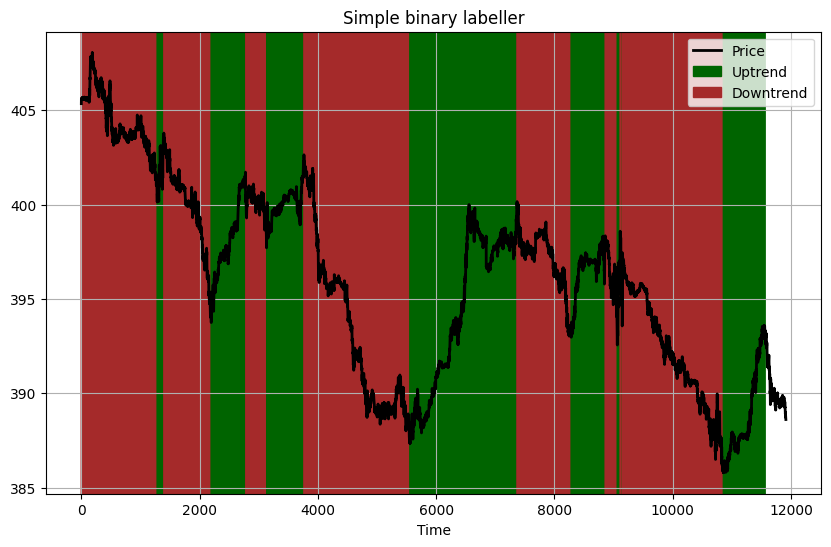

In [6]:
binary_labeller = BinaryCTL(omega=0.009) # omega value from the optimization in simple_labeller_howto.py
labels = binary_labeller.get_labels(concatenated_closing_prices[::-1])
print(f"Uptrend periods: {Counter(labels)[1]}, Downtrend periods: {Counter(labels)[-1]}")
plot_trend_labels(concatenated_closing_prices[::-1], labels, title="Simple binary labeller")


# Optimise different labellers

In [9]:
from src.returns_estimation.returns_estimation import ReturnsEstimatorWithFees
from src.trend_labelling.oracle_labeller import OracleBinaryTrendLabeller

fees_config = FeesConfig(
    lp_transaction_fees=0.009, # Higher fees discourage frequent label changes
    sp_transaction_fees=0.009,
    lp_holding_fees=0.0001,
    sp_holding_fees=0.0001
)
custom_bounds = {
    "transaction_cost": (0, 0.01),
}
# Let's repeat the optimisation with the new return estimator.
opt = Optimiser(ReturnsEstimatorWithFees(fees_config), initial_points=10, nb_iter=80)
opt.optimise(OracleBinaryTrendLabeller, concatenated_closing_prices, custom_bounds, verbose=1)



|   iter    |  target   | transa... |
-------------------------------------
1210.0493654999998
1211.2406654999997
380.5632000000004
377.4010896
378.5923896
247.83420000000035
| 2         | -130.8    | 0.001427  |
24.7640067
25.9553067
75.49560000000008
| 3         | 49.54     | 0.009299  |
42.676391699999996
43.867691699999995
102.64560000000006
| 4         | 58.78     | 0.005909  |
42.676391699999996
43.867691699999995
102.64560000000006
114.02904059999999
115.22034059999999
159.29740000000027
306.3485727
307.5398727
228.72860000000014
78.3426006
79.5339006
136.7918000000002
78.3426006
79.5339006
136.7918000000002
31.883636699999997
33.074936699999995
86.87560000000008
24.7640067
25.9553067
75.49560000000008
24.7640067
25.9553067
75.49560000000008
42.676391699999996
43.867691699999995
102.64560000000006
31.883636699999997
33.074936699999995
86.87560000000008
42.676391699999996
43.867691699999995
102.64560000000006
85.63206059999999
86.82336059999999
142.13180000000023
149.8076406
150.

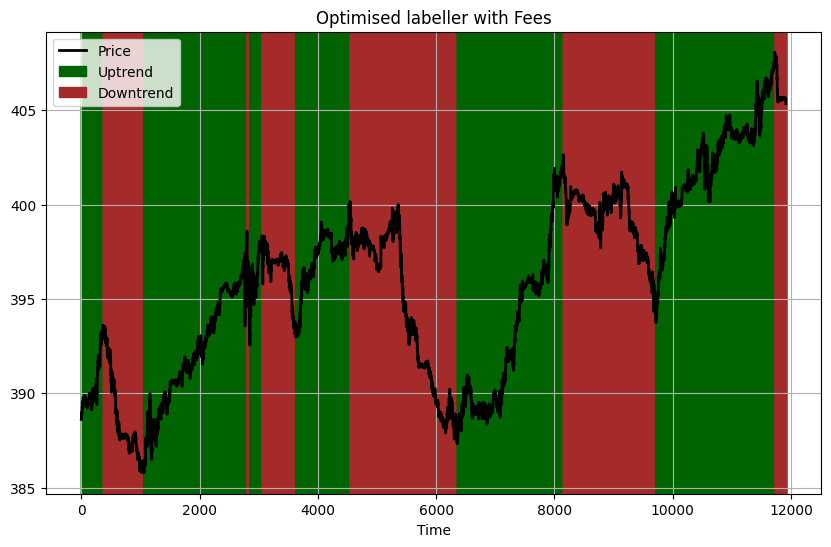

In [8]:
labeller = OracleBinaryTrendLabeller(**opt.optimiser.max['params'])
labels = labeller.get_labels(concatenated_closing_prices)
plot_trend_labels(concatenated_closing_prices, labels, title="Optimised labeller with Fees")

The FeesConfig class also allows to prioritise one position over the other. Let's for example increase the fees for the long position.


In [ ]:
from trend_labelling.ternary_CTL import TernaryCTL

custom_bounds = {
    "marginal_change_thres": (0, 0.1),
    "window_size": (1, 3000),
}
fees_config = FeesConfig(
    lp_transaction_fees=0.009, # Higher fees discourage frequent label changes
    sp_transaction_fees=0.009
)
opt = Optimiser(ReturnsEstimatorWithFees(fees_config), initial_points=10, nb_iter=80)
opt.optimise(TernaryCTL, concatenated_closing_prices, custom_bounds, verbose=1)


|   iter    |  target   | margin... | window... |
-------------------------------------------------
| 3         | -1.607    | 0.01803   | 198.8     |
| 4         | 6.689     | 0.02808   | 2.679e+03 |
| 12        | 9.181     | 0.006739  | 2.678e+03 |
| 20        | 10.68     | 0.01796   | 1.651e+03 |
| 25        | 29.19     | 0.01206   | 1.515e+03 |
| 78        | 30.94     | 0.01143   | 2.939e+03 |


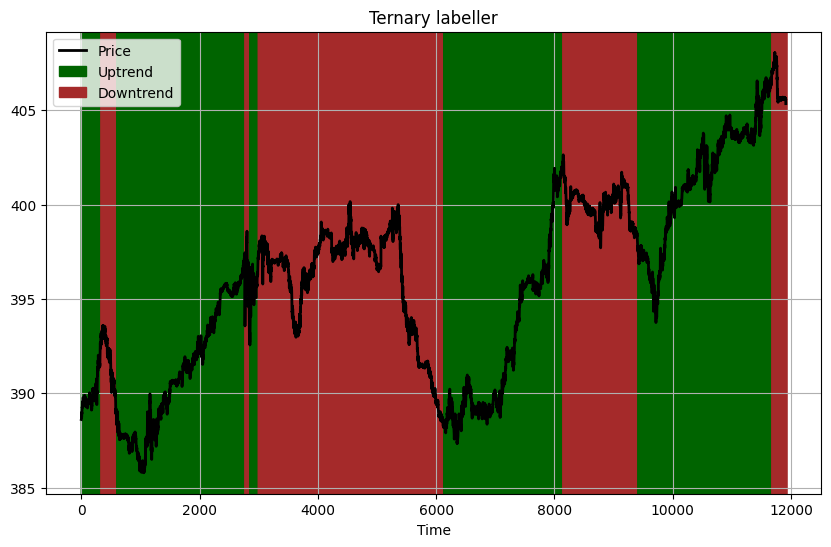

In [10]:
labeller = TernaryCTL(marginal_change_thres = opt.optimiser.max['params']["marginal_change_thres"], window_size = int(opt.optimiser.max['params']["window_size"]))
labels = labeller.get_labels(concatenated_closing_prices)
plot_trend_labels(concatenated_closing_prices, labels, title=f"Ternary labeller")

We see that the algorithm get more picky when labelling upward trends.

In [11]:
len(concatenated_closing_prices)

11913

In [75]:
from src.trend_labelling.base_labeller import BaseLabeller
from src.trend_labelling.label_scaling import Labels


class TernaryCTL(BaseLabeller):
    """
    Three-states continuous trend labeller class, adapted from the original paper by
    Dezhkam, Arsalan et al. "A Bayesian-based classification framework for financial time series trend prediction."
    https://doi.org/10.1007/s11227-022-04834-4
    """

    def __init__(self, marginal_change_thres: float, window_size: int) -> None:
        """
        Initialize the ternary trend labeller.

        Args:
            marginal_change_thres (float): The threshold for significant price movements as a percentage.
            window_size (int): The maximum window to look for trend confirmation before resetting state.
        """
        if not isinstance(marginal_change_thres, float):
            raise TypeError("marginal_change_thres must be a float.")
        if not isinstance(window_size, int):
            raise TypeError("window_size must be an integer.")

        self.marginal_change_thres = marginal_change_thres
        self.window_size = window_size
        self.labels: list[Labels] = list()

    def _get_first_label(self, time_series_list: list[float]) -> None:
        """
        Find upward trends in a time series of closing prices. This is the first step of the ternary trend labelling algorithm.

        Args:
            time_series_list (list[float]): List of closing prices.
        """
        if time_series_list[0] > time_series_list[1]:
            return [Labels.DOWN]
        return [Labels.UP]

    def _is_significant_upward_move(self, current: float, reference: float) -> bool:
        """
        Check if a current price is a significant upward move compared to a reference price.

        Args:
            current (float): The current price.
            reference (float): The reference price.

        Returns:
            bool: True if the current price is a significant upward move, False otherwise.
        """
        return current >= reference * (1 + self.marginal_change_thres)

    def _is_significant_downward_move(self, current: float, reference: float) -> bool:
        """
        Check if a current price is a significant downward move compared to a reference price.

        Args:
            current (float): The current price.
            reference (float): The reference price.

        Returns:
            bool: True if the current price is a significant downward move, False otherwise.
        """
        return current <= reference * (1 - self.marginal_change_thres)

    def _generate_label_values(self) -> list[int]:
        """Convert Labels enum to their integer values"""
        return [label.value for label in self.labels]

    def _right_pad_labels(self, total_length: int) -> list[int]:
        """
        Right pad the labels list by duplicating the last element.
        Args:
            total_length (int): The target length of the padded list.

        Returns:
            list[Labels]: Padded list of label values with length equal to target_length.
        """
        if len(self.labels) == 0:
            return []
        self.labels += [self.labels[-1]]*(total_length-len(self.labels))

    def _update_labels(self, trend_start: int, current_idx: int, label: Labels) -> None:
        """
        Update the labels list with a new label value.

        Args:
            trend_start (int): The starting index of the trend.
            current_idx (int): The current index of the price.
            label (Labels): The new label value to be added.
        """
        self.labels += [label]*(current_idx-trend_start)
    
    def _has_price_crossed_reference_price(self, previous_price: float, current_price: float, reference_price: float) -> bool:
        """
        Check if the price has crossed the reference price.
        """
        return (previous_price - reference_price) * (current_price - reference_price) <= 0

    def get_labels(
        self,
        prices: list[float],
    ) -> list[int]:
        """
        Labels trends in a time series of closing prices using a ternary classification approach.
        The method identifies three distinct states in price movements:
            - Upward trends (label: Labels.UP)
            - Downward trends (label: Labels.DOWN)
            - No-action (label: Labels.NEUTRAL)

        The algorithm uses two key parameters:
            - marginal_change_thres: Defines the threshold for significant price movements as a percentage
            - window_size: Maximum window to look for trend confirmation before resetting state

        The labeling process works by tracking the current state and transitioning between
        states when price movements exceed thresholds, while using the window_size parameter
        to avoid getting stuck in prolonged sideways movements.

        Parameters:
            prices (list[float]): List of closing prices.

        Returns:
            list[int]: List of labels where Labels.UP indicates an upward trend,
                    Labels.DOWN indicates a downward trend, and Labels.NEUTRAL indicates no-action.
        """
        self._verify_time_series(prices)
        # Initialize labels
        self.labels = self._get_first_label(prices)
        # Initialize trend start index
        trend_start = 0
        # Iterate over prices starting from the second price
        for current_idx, current_price in enumerate(prices[1:], start=1):
            reference_price = prices[trend_start]
            window_exceeded = current_idx - trend_start > self.window_size

            match self.labels[-1]:
                case Labels.UP:  # Upward trend
                    if current_price > reference_price:
                        self._update_labels(trend_start, current_idx, Labels.UP)
                    elif self._is_significant_downward_move(
                        current_price, reference_price
                    ):
                        self._update_labels(trend_start, current_idx, Labels.DOWN)
                    elif window_exceeded:
                        self._update_labels(trend_start, current_idx, Labels.NEUTRAL)
                    else:
                        continue
                    trend_start = current_idx

                case Labels.DOWN:  # Downward trend
                    if current_price < reference_price:
                        self._update_labels(trend_start, current_idx, Labels.DOWN)
                    elif self._is_significant_upward_move(
                        current_price, reference_price
                    ):
                        self._update_labels(trend_start, current_idx, Labels.UP)
                    elif window_exceeded:
                        self._update_labels(trend_start, current_idx, Labels.NEUTRAL)
                    else:
                        continue
                    trend_start = current_idx

                case Labels.NEUTRAL:  # No trend
                    if self._is_significant_upward_move(current_price, reference_price):
                        self._update_labels(trend_start, current_idx, Labels.UP)
                    elif self._is_significant_downward_move(
                        current_price, reference_price
                    ):
                        self._update_labels(trend_start, current_idx, Labels.DOWN)
                    elif window_exceeded:
                        self._update_labels(trend_start, current_idx, Labels.NEUTRAL)
                    else:
                        continue
                    trend_start = current_idx

        self._right_pad_labels(len(prices))
        return self._generate_label_values()


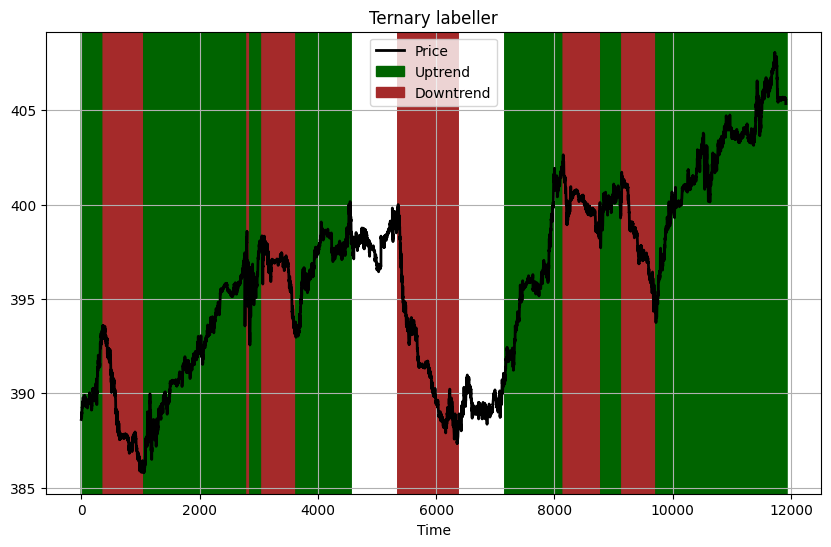

In [76]:
labeller = TernaryCTL(marginal_change_thres = 0.01, window_size = 800)
labels = labeller.get_labels(concatenated_closing_prices)
plot_trend_labels(concatenated_closing_prices, labels, title=f"Ternary labeller")

In [29]:
labeller.labels = list()
labeller._find_initial_trend(concatenated_closing_prices)
labeller.labels[5915:5925]

[<Labels.DOWN: -1>,
 <Labels.DOWN: -1>,
 <Labels.DOWN: -1>,
 <Labels.DOWN: -1>,
 <Labels.DOWN: -1>,
 <Labels.DOWN: -1>,
 <Labels.DOWN: -1>,
 <Labels.DOWN: -1>,
 <Labels.DOWN: -1>,
 <Labels.DOWN: -1>]

In [47]:
# Get length of each contiguous group of labels with the same value


for i in range(len(labels)):
    if labels[i] != labels[i-1]:
        print(i, labels[i])


0 1
320 -1
1054 1
1161 -1
1190 1
1500 -1
1703 1
2277 -1
2767 1
2791 -1
2850 1
2869 -1
3629 1
3937 0
4738 -1
6357 0
7158 1
7932 -1
7934 1
8146 -1
8781 1
9137 -1
9715 1
9794 -1
9826 1
9987 -1
10031 1
10505 -1
10629 1
10872 -1
11368 1
11685 -1


In [14]:
from typing import List
import numpy as np
from numpy.typing import NDArray
from src.trend_labelling import BaseLabeller


class OracleTernaryTrendLabeller(BaseLabeller):
    """
    Oracle Ternary Trend Labeller class that identifies three states: downtrend (0), neutral (1), and uptrend (2).
    Transitions between downtrend and uptrend must go through the neutral state.
    """

    def __init__(self, transition_reward: float, neutral_reward_factor: float) -> None:
        """
        Initialize the ternary trend labeller.

        Args:
            transition_reward (float): Reward coefficient for switching between trends.
            neutral_reward_factor (float): Trend coefficient.
        """
        if not isinstance(transition_reward, float):
            raise TypeError("transition_reward must be a float.")
        self.transition_reward = transition_reward
        self.neutral_reward_factor = neutral_reward_factor

    def _verify_time_series(self, time_series_list: list[float]) -> None:
        """
        Verify the input time series.
        
        Args:
            time_series_list (list[float]): The price series.
        """
        if not isinstance(time_series_list, list):
            raise TypeError("time_series_list must be a list.")
        if not all(isinstance(price, (int, float)) for price in time_series_list):
            raise TypeError("All elements in time_series_list must be integers or floats.")
        if len(time_series_list) < 2:
            raise ValueError("time_series_list must contain at least two elements.")

    def _compute_transition_rewards(self, time_series_arr: NDArray) -> NDArray:
        """
        Initialize the transition reward matrix for three states.
        
        Args:
            time_series_arr (NDArray): Array of price values.
        Returns:
            NDArray: Transition reward matrix of shape (T-1, 3, 3).
        """
        T = len(time_series_arr)
        P = np.full((T - 1, 3, 3), -np.inf)  # Initialize with -inf for forbidden transitions

        for t in range(T - 1):
            price_change = time_series_arr[t + 1] - time_series_arr[t]
            switch_cost = -time_series_arr[t] * self.transition_reward

            # Rewards for staying in same state
            P[t, 0, 0] = -price_change  # Reward for staying in downtrend
            P[t, 1, 1] = abs(price_change)*self.neutral_reward_factor  # No reward for staying neutral
            P[t, 2, 2] = price_change  # Reward for staying in uptrend

            # Rewards for allowed transitions
            P[t, 0, 1] = switch_cost  # Downtrend to neutral
            P[t, 1, 0] = switch_cost  # Neutral to downtrend
            P[t, 1, 2] = switch_cost  # Neutral to uptrend
            P[t, 2, 1] = switch_cost  # Uptrend to neutral

        return P

    def _forward_pass(self, time_series_arr: NDArray, P: NDArray) -> NDArray:
        """
        Perform the forward pass to calculate the state matrix.
        
        Args:
            time_series_arr (NDArray): Array of price values.
            P (NDArray): Transition reward matrix.
            
        Returns:
            NDArray: State matrix of cumulative returns.
        """
        T = len(time_series_arr)
        S = np.zeros((T, 3))  # Initialize state matrix for 3 states

        # Iterate over time steps in forward direction
        for t in range(1, T):
            # Maximum return for being in downtrend
            S[t, 0] = max(
                S[t-1, 0] + P[t-1, 0, 0],  # Stay in downtrend
                S[t-1, 1] + P[t-1, 1, 0]   # Switch from neutral
            )

            # Maximum return for being in neutral
            S[t, 1] = max(
                S[t-1, 0] + P[t-1, 0, 1],  # Switch from downtrend
                S[t-1, 1] + P[t-1, 1, 1],  # Stay in neutral
                S[t-1, 2] + P[t-1, 2, 1]   # Switch from uptrend
            )

            # Maximum return for being in uptrend
            S[t, 2] = max(
                S[t-1, 1] + P[t-1, 1, 2],  # Switch from neutral
                S[t-1, 2] + P[t-1, 2, 2]   # Stay in uptrend
            )

        return S

    def _backward_pass(self, S: NDArray, P: NDArray, time_series_arr: NDArray) -> NDArray:
        """
        Perform the backward pass to determine the trend labels.
        
        Args:
            S (NDArray): State matrix of cumulative returns.
            P (NDArray): Transition reward matrix.
            time_series_arr (NDArray): Array of price values.
            
        Returns:
            NDArray: Optimal trend labels (0 for downtrend, 1 for neutral, 2 for uptrend).
        """
        T = len(time_series_arr)
        labels = np.zeros(T, dtype=int)
        labels[-1] = np.argmax(S[-1])  # Start from the last state

        for t in range(T - 2, -1, -1):
            # Find state that maximizes return considering next state's label
            rewards = S[t] + P[t, :, labels[t + 1]]
            labels[t] = np.argmax(rewards)

        return labels

    def get_labels(self, time_series_list: list[float]) -> list[int]:
        """
        Run the full Oracle Ternary Trend Labeling Algorithm over a time series.
        
        Args:
            time_series_list (list[float]): The price series.
            
        Returns:
            list[int]: Optimal trend labels (0 for downtrend, 1 for neutral, 2 for uptrend).
        """
        self._verify_time_series(time_series_list)
        time_series_arr = np.array(time_series_list)

        P = self._compute_transition_rewards(time_series_arr)
        S = self._forward_pass(time_series_arr, P)
        labels = self._backward_pass(S, P, time_series_arr)

        return labels.tolist(), P, S

Counter({-1: 1311, 0: 941, 1: 748})


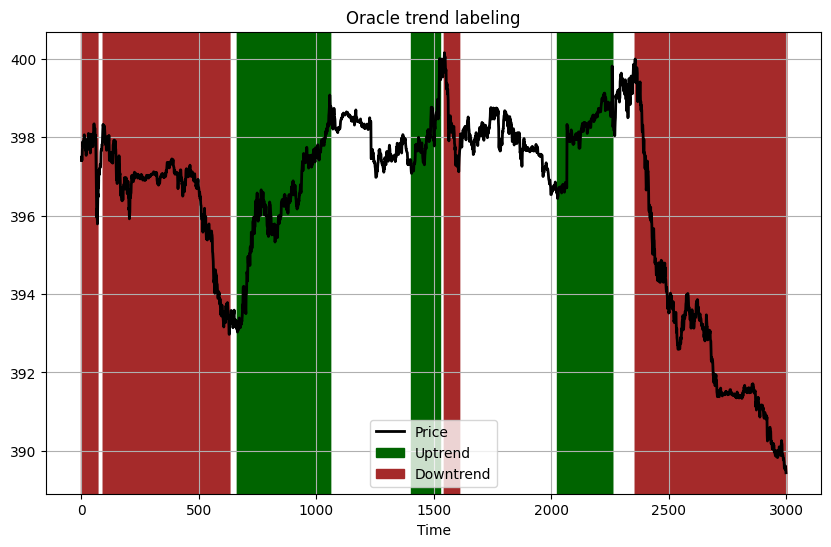

In [15]:
labels, P, S = OracleTernaryTrendLabeller(0.003, 0.03).get_labels(concatenated_closing_prices[3000:6000][::1])
# Substract 1 to each label
labels = [label - 1 for label in labels][1:]+[0]
print(Counter(labels))
plot_trend_labels(concatenated_closing_prices[3000:6000][::1], labels, title="Oracle trend labeling")

In [16]:
labels = [0,0,0,1,1,1,1]
Counter(np.array(labels)/np.array(labels).max()*2-1)

Counter({np.float64(1.0): 4, np.float64(-1.0): 3})

Counter({-1: 127, 1: 73})


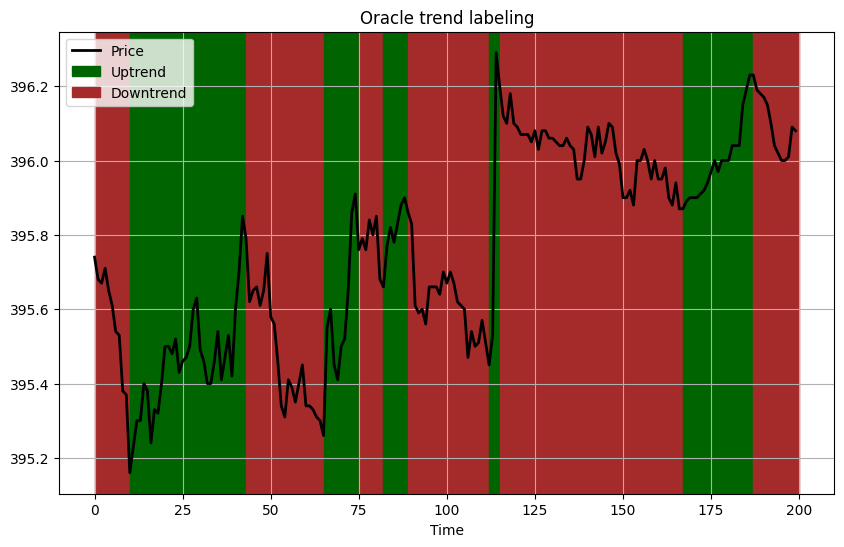

In [17]:
labels= OracleBinaryTrendLabeller(0.0003).get_labels(concatenated_closing_prices[7550:7750][::-1])
# Substract 1 to each label
print(Counter(labels))
plot_trend_labels(concatenated_closing_prices[7550:7750][::-1], labels, title="Oracle trend labeling")

In [18]:
np.array(labels)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [19]:
for i in np.linspace(1, 10, 20):
    labels = OracleTernaryTrendLabeller(0.0004, i).get_labels(concatenated_closing_prices[::-1])
    # Count the number of intervals of contiguous labels with the same value
    nb_distinct_groups = sum(1 for i in range(len(labels)) if labels[i] != labels[i-1])
    print(round(i,4), nb_distinct_groups, sum(label==1 for label in labels))



ValueError: operands could not be broadcast together with shapes (11913,3) (11913,) 